In [9]:
# Packages Load
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
import os
warnings.filterwarnings("ignore")
tf.__version__
print("package loaded")

package loaded


In [10]:
# os
cwd = (r'C:\Users\heon1\Desktop\AFTER_PRERROCESSING')
os.chdir(cwd)
os.getcwd()
print(os.getcwd())

C:\Users\heon1\Desktop\AFTER_PRERROCESSING


In [11]:
# Load Data
df = pd.read_csv(cwd+ r"\HM.csv") #encoding = 'UTF-8')
df.describe()
df
df.columns

Index(['Date', 'Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', 'wti',
       'gold', 'nasdac', 'cospi', 'usd', 'avg_5_adj', 'avg_5_vol', 'adjrate',
       'classification'],
      dtype='object')

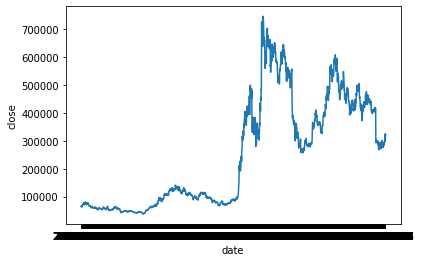

In [12]:
# PLOT
plt.plot(df['Date'], df['Close'])
plt.xlabel('date')
plt.ylabel('close')
plt.show()


In [18]:
# Preprocessing
df.drop(['Date'],axis=1, inplace=True)
print(df.columns)
print(df.dtypes)
print(df.shape)

Index(['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', 'wti', 'gold',
       'nasdac', 'cospi', 'usd', 'avg_5_adj', 'avg_5_vol', 'adjrate',
       'classification'],
      dtype='object')
Open              float64
Close             float64
High              float64
Low               float64
Adj Close         float64
Volume              int64
wti               float64
gold              float64
nasdac            float64
cospi             float64
usd               float64
avg_5_adj         float64
avg_5_vol         float64
adjrate           float64
classification      int64
dtype: object
(2132, 15)


In [14]:
# Normalization
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7)  # 1e-7은 0으로 나누는 오류 예방차원

# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [49]:
norm_price = min_max_scaling(df[df.columns[0:5]])
norm_price2 = min_max_scaling(df[df.columns[-4]])
volumn = min_max_scaling(df[df.columns[5]])
volumn2 = min_max_scaling(df[df.columns[-3]])
print(norm_price.shape)
print(volumn.shape)
print(norm_price2.shape)
print(volumn2.shape)

(2132, 5)
(2132,)
(2132,)
(2132,)


In [74]:
tmp = np.array(df[df.columns[6:11]])
print(tmp.shape)
volumn = np.reshape(volumn,((-1,1)))
volumn2 = np.reshape(volumn2,((-1,1)))
norm_price2 = np.reshape(norm_price2, ((-1,1)))


(2132, 5)


In [77]:
# x,y 분할
x= np.concatenate((norm_price, norm_price2, volumn, volumn2, tmp), axis=1)
y= np.array(df['adjrate'])
print(x.shape)
print(y[:5])

(2132, 13)
[ 0.09204534  0.00936566 -0.00618584  0.         -0.02489563]


In [78]:
# 하이퍼파라미터
input_data_column_cnt = 13  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1  # 결과데이터의 컬럼 개수
seq_length = 28  # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20  # 각 셀의 (hidden)출력 크기
forget_bias = 1.0  # 망각편향(기본값 1.0)
num_stacked_layers = 1  # stacked LSTM layers 개수
keep_prob = 1.0  # dropout할 때 keep할 비율
epoch_num = 1000  # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01  # 학습률

In [79]:
dataX = []  # 입력으로 사용될 Sequence Data
dataY = []  # 출력(타켓)으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i: i + seq_length]
    _y = y[i + seq_length]  # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y)  # 첫번째 행만 출력해 봄
    dataX.append(_x)  # dataX 리스트에 추가
    dataY.append(_y)  # dataY 리스트에 추가

# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size


[[ 3.00218835e-02  3.72895302e-02  3.81175243e-02  2.99298824e-02
   3.69093093e-02  3.36748356e-02  6.54368284e-02  1.01207575e-01
  -1.60000000e-02  5.20000000e-03 -2.00000000e-03  0.00000000e+00
  -4.90000000e-03]
 [ 3.65536755e-02  3.81175243e-02  4.27173354e-02  3.60016795e-02
   3.77337469e-02  3.48543859e-02  5.88993318e-02  9.44022606e-02
   9.70000000e-03 -2.20000000e-03  7.50000000e-03  3.60000000e-03
  -9.00000000e-04]
 [ 3.83015159e-02  3.75655283e-02  3.90375142e-02  3.64616744e-02
   3.71841218e-02  3.58766535e-02  2.16509673e-02  9.21908725e-02
  -1.51000000e-02 -3.70000000e-03 -1.24000000e-02 -5.00000000e-03
   7.10000000e-03]
 [ 3.71056662e-02  3.75655283e-02  3.87615108e-02  3.61856764e-02
   3.71841218e-02  3.68989210e-02  2.39024724e-02  8.26686120e-02
  -2.78000000e-02  1.10000000e-03 -3.01000000e-02 -1.29000000e-02
   1.18000000e-02]
 [ 3.63696733e-02  3.53576876e-02  3.79335221e-02  3.53576876e-02
   3.49857758e-02  3.80784987e-02  2.36046331e-02  7.01765247e-02


In [103]:
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
trainY = np.reshape(trainY, ((-1,1)))
print(trainX.shape)
print(trainY.shape)
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])
testY = np.reshape(testY, ((-1,1)))

(1472, 28, 13)
(1472, 1)


In [81]:
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)


X:  Tensor("Placeholder:0", shape=(?, 28, 13), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [82]:
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)

predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [85]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim,
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell


In [86]:
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [88]:
# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)
#tf.Session.close()

hypothesis:  Tensor("rnn_1/transpose_1:0", shape=(?, 28, 20), dtype=float32)


In [89]:
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임

train = optimizer.minimize(loss)


In [90]:
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

train_error_summary = []  # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''  # 테스트용데이터로 예측한 결과


In [93]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
import  datetime
start_time = datetime.datetime.now()  # 시작시간을 기록한다

In [104]:

print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch + 1) % 100 == 0) or (epoch == epoch_num - 1):  # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)

        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)

        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch + 1, train_error, test_error,
                                                                                 test_error - train_error))

end_time = datetime.datetime.now()  # 종료시간을 기록한다
elapsed_time = end_time - start_time  # 경과시간을 구한다
print('elapsed_time:', elapsed_time)
print('elapsed_time per epoch:', elapsed_time / epoch_num)


학습을 시작합니다...
epoch: 100, train_error(A): 0.030919069424271584, test_error(B): 0.025115516036748886, B-A: -0.0058035533875226974
epoch: 200, train_error(A): 0.03071466088294983, test_error(B): 0.025146296247839928, B-A: -0.005568364635109901
epoch: 300, train_error(A): 0.03049272857606411, test_error(B): 0.02521885558962822, B-A: -0.00527387298643589
epoch: 400, train_error(A): 0.030196497216820717, test_error(B): 0.025352289900183678, B-A: -0.004844207316637039
epoch: 500, train_error(A): 0.029853565618395805, test_error(B): 0.025542140007019043, B-A: -0.004311425611376762
epoch: 600, train_error(A): 0.02940407767891884, test_error(B): 0.02569751814007759, B-A: -0.0037065595388412476
epoch: 700, train_error(A): 0.029120085760951042, test_error(B): 0.029657388105988503, B-A: 0.0005373023450374603
epoch: 800, train_error(A): 0.027238676324486732, test_error(B): 0.03315546363592148, B-A: 0.005916787311434746
epoch: 900, train_error(A): 0.024502204731106758, test_error(B): 0.03761807084083

In [105]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')

print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')

print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')

print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

input_data_column_cnt: 13,output_data_column_cnt: 1,seq_length: 28,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 1000,learning_rate: 0.01,train_error: 0.02330254,test_error: 0.041877165,min_test_error: 0.025115516


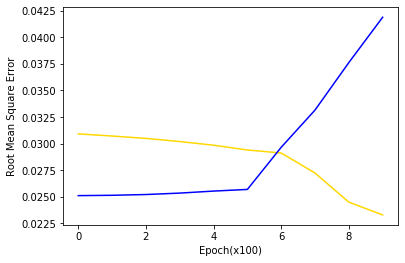

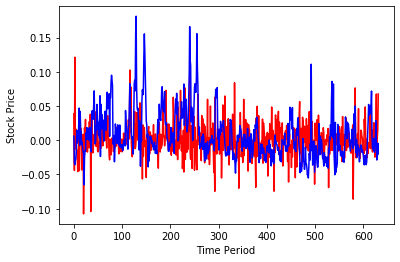

In [106]:
# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()


In [107]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x) - seq_length:]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)


recent_data.shape: (1, 28, 13)
recent_data: [[[ 3.40149514e-01  3.59202559e-01  3.65326752e-01  3.37427650e-01
    3.59202559e-01  3.60832073e-01  5.17721435e-02  4.63628825e-02
   -5.66000000e-02  1.30000000e-03  4.00000000e-03  1.00000000e-04
    2.20000000e-03]
  [ 3.62604888e-01  3.57161161e-01  3.62604888e-01  3.55800229e-01
    3.57161161e-01  3.66527754e-01  1.12904521e-02  4.79784845e-02
   -2.07000000e-02  1.60000000e-03 -1.10000000e-03  4.10000000e-03
    3.50000000e-03]
  [ 3.57841627e-01  3.51036968e-01  3.61243956e-01  3.48995570e-01
    3.51036968e-01  3.72515522e-01  2.12294026e-02  4.40339556e-02
    3.00000000e-04 -6.30000000e-03  7.00000000e-04  4.60000000e-03
    3.00000000e-03]
  [ 3.52397900e-01  3.51717434e-01  3.55800229e-01  3.50356502e-01
    3.51717434e-01  3.76166600e-01  1.29542610e-02  3.80995616e-02
   -7.00000000e-04  5.90000000e-03 -8.00000000e-03  5.40000000e-03
   -1.00000000e-03]
  [ 3.50356502e-01  3.41510446e-01  3.51036968e-01  3.40829980e-01
    3

In [109]:
# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict[0])
#test_predict = reverse_min_max_scaling(price, test_predict)  # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0])  # 예측한 주가를 출력한다


test_predict [-0.0294898]
Tomorrow's stock price [-0.0294898]
